## References

https://stackoverflow.com/questions/69195950/problem-with-inputs-when-building-a-model-with-tfbertmodel-and-autotokenizer-fro

In [67]:
import json
from pathlib import Path
from typing import List

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import keras.layers as L
import keras.models as M
import keras.losses as LL
import tensorflow_datasets as tfds
import tensorflow_models as tfm
import transformers
from transformers import AutoTokenizer, TFDistilBertForTokenClassification

from conlleval import evaluate

In [2]:
(ds_train, ds_val, ds_test), info = tfds.load("conll2003", with_info=True, split=["train", "dev", "test"])

2023-01-10 04:32:27.669576: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/calcifer/git/marco/learn-deep-learning/.env/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-10 04:32:27.669890: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-10 04:32:27.669919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (calcifer-Inspiron-7370): /proc/driver/nvidia/version does not exist
2023-01-10 04:32:27.671474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, reb

In [3]:
tag_names = ["[PAD]"] + info.features["ner"].names
tag_ids = range(len(tag_names))
label_ids_to_tags = dict(enumerate(tag_names))
tag_names

['[PAD]',
 'O',
 'B-PER',
 'I-PER',
 'B-ORG',
 'I-ORG',
 'B-LOC',
 'I-LOC',
 'B-MISC',
 'I-MISC']

In [4]:
sample = ds_train.as_numpy_iterator().next()
sample

2023-01-10 04:32:27.975003: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'chunks': array([ 0, 17, 11, 21, 22, 11, 12, 12, 12,  0,  3, 11, 12, 12, 21, 22, 22,
        11, 12, 12, 12,  0,  0, 21, 11, 12, 12, 12, 11, 21, 22, 22, 22,  0]),
 'ner': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]),
 'pos': array([ 0, 15, 28, 41, 39, 15, 18, 11, 21,  6, 30, 29, 16, 24, 41, 30, 39,
        11, 10, 11, 21,  6,  0, 38, 11, 22, 24, 21, 44, 38, 35, 37, 40,  7]),
 'tokens': array([b'"', b'If', b'they', b"'re", b'saying', b'at', b'least', b'20',
        b'percent', b',', b'then', b'their', b'internal', b'forecasts',
        b'are', b'probably', b'saying', b'25', b'or', b'30', b'percent',
        b',', b'"', b'said', b'one', b'Sydney', b'media', b'analyst',
        b'who', b'declined', b'to', b'be', b'named', b'.'], dtype=object)}

## Prepare the dataset

In [5]:
VOCAB_FILE = Path.cwd() / "vocab.txt"

TRANSFORMER_MODEL_NAME = "distilbert-base-cased"

In [6]:
transformers_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

In [7]:
df = (
    pd.DataFrame.from_dict(transformers_tokenizer.get_vocab(), orient="index")
    .reset_index()
    .rename({"index": "token", 0: "idx"}, axis=1)
    .sort_values("idx")
    .reset_index(drop=True)
)
df.head()

,token,idx
0,[PAD],0
1,[unused1],1
2,[unused2],2
3,[unused3],3
4,[unused4],4


In [8]:
df["token"].to_csv(path_or_buf=VOCAB_FILE, index=False, header=False)

## Create the tokenizer

In [9]:
tokenizer = tfm.nlp.layers.BertTokenizer(
    vocab_file=VOCAB_FILE.as_posix(),
    lower_case=False,
    tokenize_with_offsets=True,
)

In [10]:
sample = (
    ds_train.map(lambda r: r["tokens"])
    .take(1)
    .as_numpy_iterator().next()
)
sample

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2023-01-10 04:32:28.763499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([b'"', b'If', b'they', b"'re", b'saying', b'at', b'least', b'20',
       b'percent', b',', b'then', b'their', b'internal', b'forecasts',
       b'are', b'probably', b'saying', b'25', b'or', b'30', b'percent',
       b',', b'"', b'said', b'one', b'Sydney', b'media', b'analyst',
       b'who', b'declined', b'to', b'be', b'named', b'.'], dtype=object)

In [11]:
tokens, offsets_start, offsets_end = tokenizer(sample)
np_tokens = tokens.merge_dims(0, 1).merge_dims(0, 1).numpy()
print(f"{np_tokens=}")
print(f"{tokens=}")

np_tokens=array([  100,  1409,  1152,   112,  1231,  2157,  1120,  1655,  1406,
        3029,   100,  1173,  1147,  4422, 24647,  1116,  1132,  1930,
        2157,  1512,  1137,  1476,  3029,   100,   100,  1163,  1141,
        3122,  2394, 14582,  1150,  5799,  1106,  1129,  1417,   119],
      dtype=int32)
tokens=<tf.RaggedTensor [[[100]], [[1409]], [[1152]], [[112], [1231]], [[2157]], [[1120]],
 [[1655]], [[1406]], [[3029]], [[100]], [[1173]], [[1147]], [[4422]],
 [[24647, 1116]], [[1132]], [[1930]], [[2157]], [[1512]], [[1137]],
 [[1476]], [[3029]], [[100]], [[100]], [[1163]], [[1141]], [[3122]],
 [[2394]], [[14582]], [[1150]], [[5799]], [[1106]], [[1129]], [[1417]],
 [[119]]]>


Check that the vocab porting was successful

In [12]:
print(*transformers_tokenizer.convert_ids_to_tokens(np_tokens))

[UNK] If they ' re saying at least 20 percent [UNK] then their internal forecast ##s are probably saying 25 or 30 percent [UNK] [UNK] said one Sydney media analyst who declined to be named .


## Prepare the dataset

### Tokenize the words and align the label sequences with the (new) tokens

In [13]:
tokenizer.get_special_tokens_dict()["start_of_sequence_id"]

101

In [14]:
@tf.function
def add_special_tokens(t: tf.Tensor) -> tf.Tensor:
    return tf.concat([
        tf.constant([tokenizer.get_special_tokens_dict()["start_of_sequence_id"]], dtype=tf.int32),
        tf.cast(t, dtype=tf.int32),
        tf.constant([tokenizer.get_special_tokens_dict()["end_of_segment_id"]], dtype=tf.int32),
    ], axis=0)  

In [15]:
def tokenize(r):
    tokens, offsets_start, offsets_end = tokenizer(r["tokens"])
    tokens_flat_0 = tokens.merge_dims(0, 1)
    tokens_flat = tokens_flat_0.merge_dims(0, 1)
    labels_aligned_0 = tf.repeat(r["ner"], tokens.row_lengths())
    labels_aligned = tf.repeat(labels_aligned_0, tokens_flat_0.row_lengths()) + 1
    tokens_out = add_special_tokens(tokens_flat)
    labels_out = tf.concat([
        tf.constant([1], dtype=tf.int32),
        tf.cast(labels_aligned, dtype=tf.int32),
        tf.constant([1], dtype=tf.int32)
    ], axis=0)  
    attention_mask = tf.ones_like(labels_out)  # unused, for now
    return tokens_out, labels_out

In [16]:
MAX_LENGTH = 10
for tokens, labels in ds_train.map(tokenize).shuffle(10).take(5):
    bert_words = transformers_tokenizer.convert_ids_to_tokens(tokens)
    print(*[f"{x:<12}" for x in bert_words][:MAX_LENGTH])
    print(*[f"{x:<12}" for x in tokens.numpy()][:MAX_LENGTH])
    print(*[f"{label_ids_to_tags[x]:<12}" for x in labels.numpy()][:MAX_LENGTH])
    print("\n")

[CLS]        We           ##rde        ##r          Bremen       3            0            1            2            4           
101          1284         14407        1197         17339        124          121          122          123          125         
O            B-ORG        B-ORG        B-ORG        I-ORG        O            O            O            O            O           


[CLS]        [UNK]        If           they         '            re           saying       at           least        20          
101          100          1409         1152         112          1231         2157         1120         1655         1406        
O            O            O            O            O            O            O            O            O            O           


[CLS]        SE           ##AT         ##TL         ##E          66           63           .            512          8           
101          12342        13821        20156        2036         5046         5519    

2023-01-10 04:32:38.692772: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
assert all(tokens.shape == labels.shape for tokens, labels in ds_train.map(tokenize).as_numpy_iterator())

## Modelling

In [18]:
RNN_UNITS = 64

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)

In [20]:
inputs = L.Input(shape=(None,), dtype=tf.int32)
distilbert = TFDistilBertForTokenClassification.from_pretrained(
    TRANSFORMER_MODEL_NAME, 
    output_hidden_states=True, 
    output_attentions=True,
    name="distilbert",
)
x = distilbert(inputs)
x = L.Dropout(0.2)(x["hidden_states"][-1])
x = L.Bidirectional(
    layer=L.GRU(units=RNN_UNITS, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    merge_mode="sum",
)(x)
x = L.TimeDistributed(layer=L.Dense(units=len(tag_names), activation="softmax"))(x)
model = M.Model(inputs=inputs, outputs=x)

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForTokenClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
out = model.predict(tokens.numpy())

1/1 [==============================] - 1s 1s/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 distilbert (TFDistilBertFor  TFTokenClassifierOutput(  65192450 
 TokenClassification)        loss=None, logits=(None,            
                              None, 2),                          
                              hidden_states=((None, N            
                             one, 768),                          
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768),                 
                              (None, None, 768)),            

## Training

In [23]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
EPOCHS = 3

In [24]:
ds_train_prep = (
    ds_train
    .map(tokenize)
    .shuffle(buffer_size=BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
)
ds_val_prep = (
    ds_train
    .map(tokenize)
    .shuffle(buffer_size=BUFFER_SIZE)
    .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
)

In [25]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [26]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match) / tf.reduce_sum(mask)

In [27]:
model.get_layer("distilbert").trainable = False

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=masked_loss,
    metrics=[masked_acc],
)

In [69]:
history = model.fit(
    ds_train_prep,
    validation_data=ds_val_prep,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    use_multiprocessing=True,
)

Epoch 1/3
439/439 [==============================] - 914s 2s/step - loss: 0.3131 - masked_acc: 0.9039 - val_loss: 0.1503 - val_masked_acc: 0.9536
Epoch 2/3
439/439 [==============================] - 871s 2s/step - loss: 0.1637 - masked_acc: 0.9497 - val_loss: 0.1124 - val_masked_acc: 0.9653
Epoch 3/3
439/439 [==============================] - 872s 2s/step - loss: 0.1318 - masked_acc: 0.9590 - val_loss: 0.0879 - val_masked_acc: 0.9725


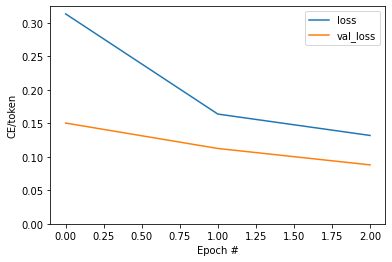

In [70]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

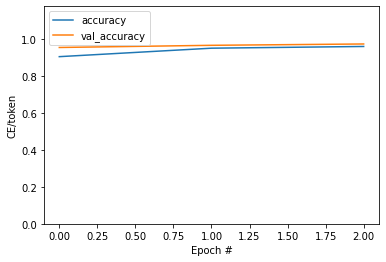

In [71]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())+.2])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Test results

In [72]:
ds_test_prep = (
    ds_test
    .map(tokenize)
    .padded_batch(1, padded_shapes=([None], [None]))
)

### Check some samples

In [73]:
for tokens, labels in ds_test_prep.take(1):
    bert_words = transformers_tokenizer.convert_ids_to_tokens(tokens.numpy().flatten())
    pred_probs = model.predict(tokens)
    pred_tag_ids = np.argmax(pred_probs, axis=-1).flatten()
    pred_tags = [label_ids_to_tags[x] for x in pred_tag_ids]
    true_tags = [label_ids_to_tags[x] for x in labels.numpy().flatten()]
    
    print("WORDS:    ", *[f"{x:<12}" for x in bert_words][:MAX_LENGTH])
    print("ACTUAL   :", *[f"{x:<12}" for x in true_tags][:MAX_LENGTH])
    print("PREDICTED:", *[f"{x:<12}" for x in pred_tags][:MAX_LENGTH])
    print("\n")

1/1 [==============================] - 1s 1s/step
WORDS:     [CLS]        Stefan       ##el         Milan        (            Italy        )            9            6            3           
ACTUAL   : O            B-ORG        B-ORG        I-ORG        O            B-LOC        O            O            O            O           
PREDICTED: O            B-PER        B-PER        I-PER        O            B-LOC        O            O            O            O           




### Evaluate metrics

Using `conlleval` function from https://keras.io/examples/nlp/ner_transformers/.

It expects two lists of entities - true and predicted, as string. Using the string as input for the metrics allows to slice the metrics for tokens corresponding to entities vs `O` tokens.

To use it:
- run the model on all records of the test dataset
- drop the predictions corresponding to padded data (and possibly to the `[CLS]` and `[SEP]` tokens)
- map the label ids to their labels
- concatenate the labels and the predicted values each in a single list each (a.k.a. one list of strings for the labels and one for the predictions)

In [74]:
def compute_metrics(ds, model):
    prob_preds_test = model.predict(ds)
    preds_test = [np.argmax(x, axis=-1) for x in prob_preds_test.to_list()]

    labels_test = [r[1] for r in ds.unbatch().as_numpy_iterator()]

    for idx in range(len(preds_test)):
        assert preds_test[idx].shape == labels_test[idx].shape
    
    preds_idx_concat, labels_idx_concat = list(), list()

    for (p, l) in zip(preds_dev, labels_dev):
        mask = l > 0
        preds_idx_concat += p[mask].tolist()
        labels_idx_concat += l[mask].tolist()

    preds_concat = [label_names[tag-1] for tag in preds_idx_concat]
    labels_concat = [label_names[tag-1] for tag in labels_idx_concat]
    
    evaluate(labels_concat, preds_concat)

In [78]:
prob_preds_test = model.predict(ds_test_prep)
preds_test = [np.argmax(x, axis=-1) for x in prob_preds_test.to_list()]

labels_test = [r[1] for r in ds_test_prep.unbatch().as_numpy_iterator()]

for idx in range(len(preds_test)):
    assert preds_test[idx].shape == labels_test[idx].shape

3454/3454 [==============================] - 116s 33ms/step


In [79]:
preds_idx_concat, labels_idx_concat = list(), list()

for p, l in zip(preds_test, labels_test):
    mask = l > 0
    preds_idx_concat += p[mask].tolist()
    labels_idx_concat += l[mask].tolist()
    
preds_concat = [tag_names[tag] for tag in preds_idx_concat]
labels_concat = [tag_names[tag] for tag in labels_idx_concat]

In [80]:
evaluate(labels_concat, preds_concat)

processed 70369 tokens with 10779 phrases; found: 10937 phrases; correct: 8490.
accuracy:  82.04%; (non-O)
accuracy:  94.83%; precision:  77.63%; recall:  78.76%; FB1:  78.19
              LOC: precision:  86.08%; recall:  78.10%; FB1:  81.89  2722
             MISC: precision:  59.71%; recall:  57.82%; FB1:  58.75  1226
              ORG: precision:  69.35%; recall:  81.61%; FB1:  74.98  4147
              PER: precision:  89.34%; recall:  84.94%; FB1:  87.09  2842


(77.62640577854988, 78.76426384636794, 78.19119543193958)